# Principal Component Analysis (PCA)

[Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) is a mechanism for reducing the number of dimensions in data. It enjoys a number of practical applications in machine learning, including obfuscating sensitive or proprietary data, eliminating multicollinearity, removing noise from datasets, and visualizing high-dimensional data by reducing it to two or three dimensions that can be plotted. PCA doesn't directly make machine-learning models more accurate, but it can help them train faster and generalize better. And PCA is easy to perform using Scikit's [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class. Let's use it to understand how PCA works and why it can be beneficial in machine learning.

![PCA](Images/pca.png)

## Understanding PCA

To understand what PCA is and how it works, we will begin by using it to reduce a 2-dimensional dataset to one dimension. The first step is to generate a dataset consisting of *x* and *y* coordinate pairs that roughly form a line.

(-3.3, 3.3, -2.2, 2.2)

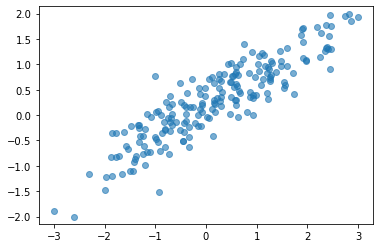

In [1]:
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
%matplotlib inline

x, y = make_regression(n_samples=200, n_features=1, noise=50, random_state=0)
x = np.interp(x, (x.min(), x.max()), (-3, 3))
y = np.interp(y, (y.min(), y.max()), (-2, 2))
data = np.column_stack((x, y))

plt.scatter(data[:, 0], data[:, 1], alpha=0.6)
plt.axis('equal')

Use PCA to find two principal components in the dataset.

In [2]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(data)

PCA(n_components=2)

Now plot the two principal components. The primary component is the axis that contains most of the information. The secondary component is the axis that contains the remaining information. Because the data points roughly form a line, the primary component lies along that line.

(-3.3, 3.3, -2.2, 2.2)

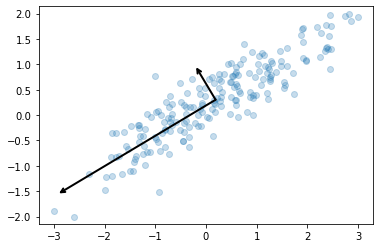

In [3]:
def draw_vector(v0, v1):
    ax = plt.gca()
    props = dict(arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=props)
    
plt.scatter(data[:, 0], data[:, 1], alpha=0.25)

for len, vector in zip(pca.explained_variance_, pca.components_):
    draw_vector(pca.mean_, pca.mean_ + (vector * 2.5 * np.sqrt(len)))

plt.axis('equal')

Use the `PCA` class's `explained_variance_ratio_` attribute to quantify the amount of information contained in each component.

In [4]:
pca.explained_variance_ratio_

array([0.95860561, 0.04139439])

More than 95% of the information in the dataset is contained in one axis (the primary component). Use PCA to reduce the dataset to one principal component.

In [5]:
pca = PCA(n_components=1)
pca_data = pca.fit_transform(data)

Now project all the data points onto the principal component axis by inverting the PCA transform, restoring the transformed data to two dimensions with information from just the first dimension. The original points are shown in blue, while the projected points are shown in orange.

(-3.4332505457710294, 3.3063452640843347, -2.2, 2.2)

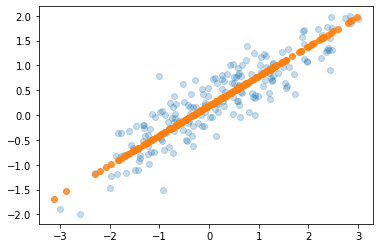

In [6]:
unpca_data = pca.inverse_transform(pca_data)
plt.scatter(data[:, 0], data[:, 1], alpha=0.25)
plt.scatter(unpca_data[:, 0], unpca_data[:, 1], alpha=0.8)
plt.axis('equal')

You can see that the orange points retain most of the information contained in the blue points, even though the size of the dataset has been cut in half (from two dimensions to one). That is the gist of PCA: reducing the number of dimensions without a commensurate loss of information.

## PCA with facial images

One of the more interesting ways to visualize how PCA can reduce the dimensions of a dataset while retaining most of the information is to apply it to the Labeled Faces in the Wild (LFW) dataset. We'll first load the dataset and reduce the number of dimensions by 95%. Then we'll invert the PCA transform to visualize how little of the original information was lost.

In [7]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100)
print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 62, 47)


Plot the first 24 images in the dataset along with their labels.

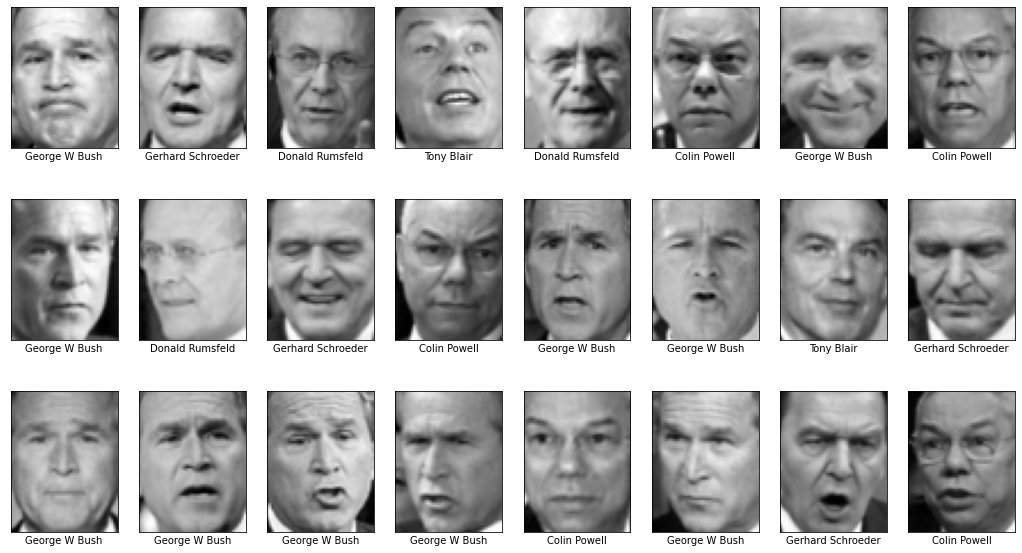

In [8]:
fig, ax = plt.subplots(3, 8, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gist_gray')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Now reduce 2,914 dimensions (62 x 47) to 150 using PCA and invert the transform to restore the facial images.

In [9]:
pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=0)
pca_faces = pca.fit_transform(faces.data)
unpca_faces = pca.inverse_transform(pca_faces).reshape(1140, 62, 47)

Show the restored facial images.

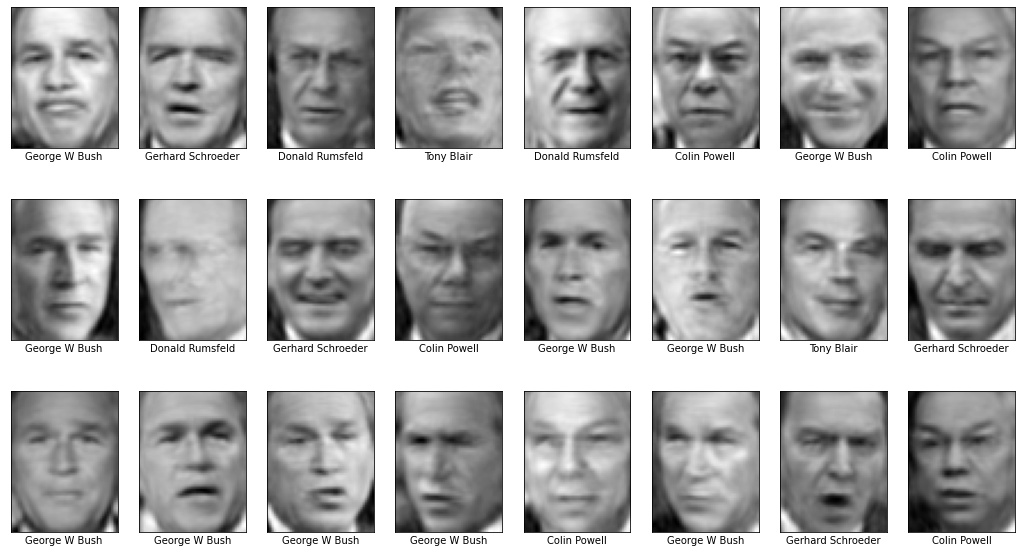

In [10]:
fig, ax = plt.subplots(3, 8, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(unpca_faces[i], cmap='gist_gray')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Compare the before and after images. Does it look as if 95% of the information was discarded?

A logical question to ask is what is the "right" number of components? In other words, what number of components strikes the best balance between reducing the number of dimensions in the dataset and retaining most of the information? One way to answer that question is a Scree chart, which plots the proportion of explained variance for each dimension. Here is a Scree chart for the PCA transform used on the facial images.

Text(0, 0.5, 'Explained Variance')

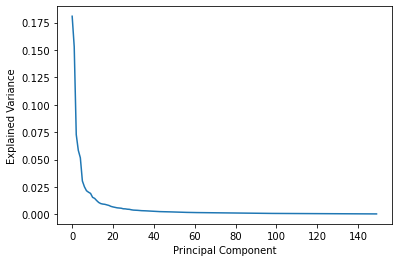

In [11]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')

Another way to look at it is to plot the sum of the variances as a function of component count.

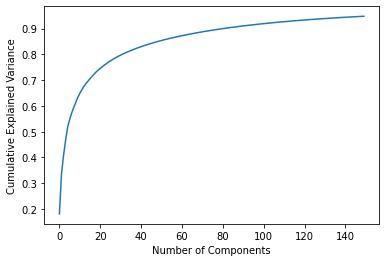

In [12]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

Based on these plots, if you had reduced the number of dimensions to 50 instead of 150, would you expect the restored facial images to look substantially different? If you're not sure of the answer, try it and see.

## PCA for noise reduction

One practical use for PCA is filtering noise from data. The basic approach is to PCA-transform the dataset, and then perform an inverse transform, taking the dataset from *m* dimensions to *n* and then back to *m*. Here we demonstrate by artificially adding noise to the handwritten-digits dataset included with Scikit-learn.

In [13]:
from sklearn.datasets import load_digits

digits = load_digits()
digits.data.shape

(1797, 64)

Plot the first 50 images and show the corresponding labels.

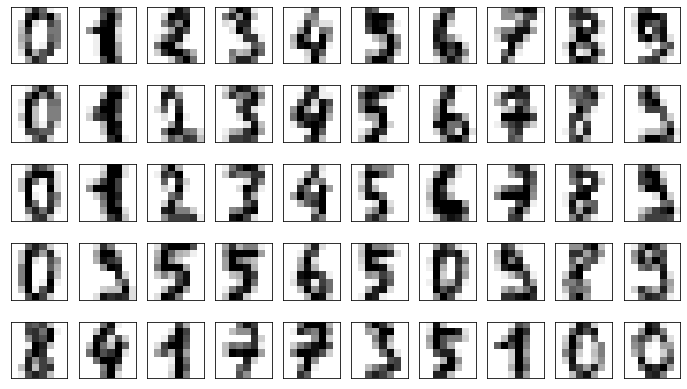

In [14]:
fig, axes = plt.subplots(5, 10, figsize=(12, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap=plt.cm.gray_r)

Introduce random noise to the dataset and plot the results.

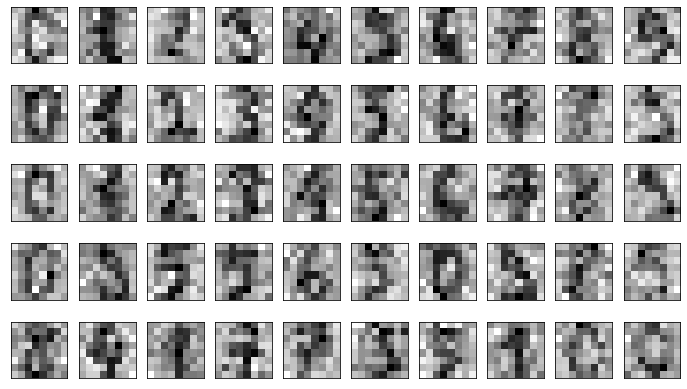

In [15]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
fig, axes = plt.subplots(5, 10, figsize=(12, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(noisy[i].reshape(8, 8), cmap=plt.cm.gray_r)

Use PCA to reduce the number of dimensions. Rather than specify the number of dimensions (components), we'll specify that we want to reduce the amount of information in the dataset to 50%. We'll let Scikit decide how many dimensions will remain, and then show the number.

In [16]:
pca = PCA(0.5).fit(noisy)
pca.n_components_

12

PCA reduced the number of dimensions from 64 to 12, but the 12 remaining dimensions contain 50% of the information in the original 64. Now reconstruct the dataset from the reduced version.

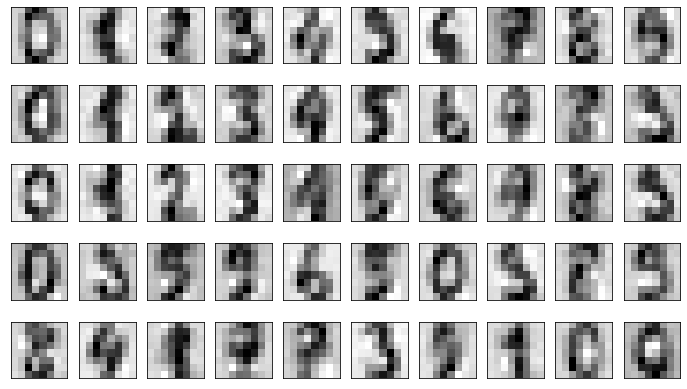

In [17]:
pca_digits = pca.transform(noisy)
unpca_digits = pca.inverse_transform(pca_digits)

fig, axes = plt.subplots(5, 10, figsize=(12, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(unpca_digits[i].reshape(8, 8), cmap=plt.cm.gray_r)

The reconstructed dataset isn't quite as clean as the original, but it's clean enough that you can make out most of the numbers.

## PCA for visualizing high-dimensional data

Another practical use for PCA is visualizing high-dimensional data. Most machine-learning models are trained with datasets containing many dimensions. For example, a dataset of 100x100-pixel images contains 10,000 dimensions. Humans can only visualize data in two or at most three dimensions. Using PCA to reduce hundreds (or thousands) of dimensions to two or three and then plotting the reduced dataset helps us visualize clusters of data in high-dimensional datasets. We'll demonstrate by using PCA to reduce the digits used in the previous example to first two and then three dimensions and plotting the results.

Start by loading the dataset and showing all 64 dimensions of the first digit in raw numerical form.

In [18]:
digits = load_digits()
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

It's impossible to plot the dataset in 64 dimensions. Reduce it to two dimensions and plot it to see if the different digits form clusters that can be classified with machine learning.

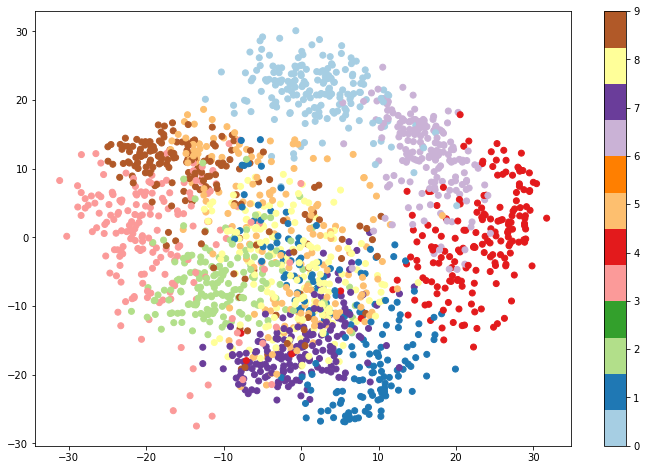

In [19]:
pca = PCA(n_components=2, svd_solver='randomized')
pca_digits = pca.fit_transform(digits.data)

plt.figure(figsize=(12, 8))
plt.scatter(pca_digits[:, 0], pca_digits[:, 1], c=digits.target, cmap='Paired')
plt.colorbar()

Reduced to two dimensions, the digits form somewhat distinct clusters, albeit with some overlap. Zeros, represented by the light blue dots, seem to have little overlap with other digits, while nines and fives exhibit some similarity, at least when viewed in two dimensions. Let's try reducing the dataset to three dimensions rather than two to see if additional separation is evident with the extra dimension.

<IPython.core.display.Javascript object>


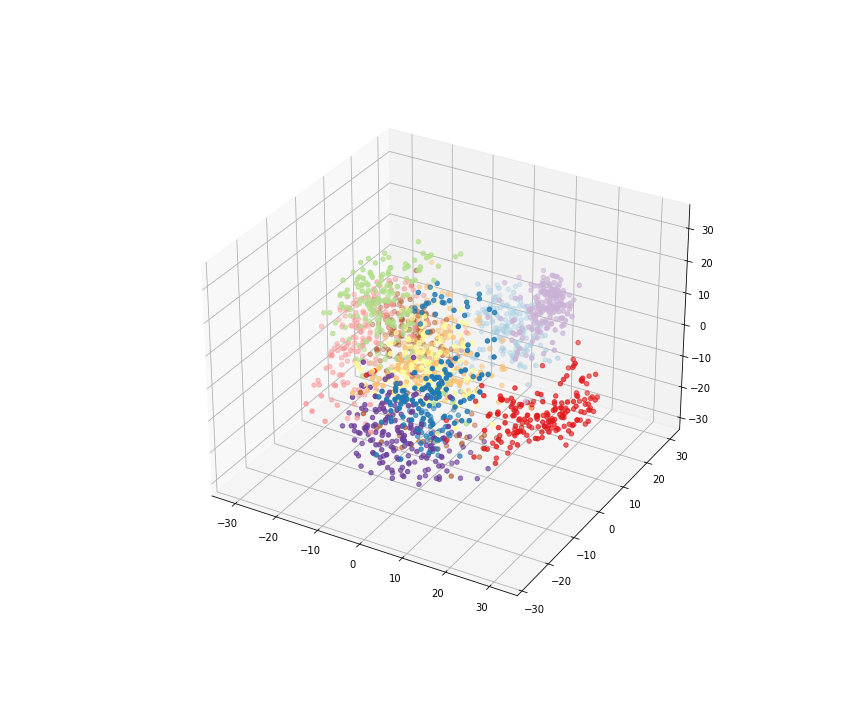

In [21]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

digits = load_digits()
pca = PCA(n_components=3, svd_solver='randomized')
pca_digits = pca.fit_transform(digits.data)

ax = plt.figure(figsize=(12, 10)).gca(projection='3d')
ax.scatter(xs = pca_digits[:, 0], ys = pca_digits[:, 1], zs = pca_digits[:, 2], c=digits.target, cmap='Paired')

Based on this visualization, is it likely that a machine-learning model could be trained to distinguish between handwritten digits with a high degree of accuracy? Observe that if you rotate the plot around various axes, you can find a reasonable degree of separation between any of the clusters.

## Data visualization with t-SNE

PCA isn't the only way to reduce the dimensionality of data. Another method — one that is particulary well-suited for visualizing high-dimensional data — is [*t*-distributed stochastic neighbor embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), or t-SNE. Scikit-learn implements t-SNE in its [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) class. Let's use it to visualize the digits dataset in two dimensions and see how it compares to the PCA visualization.

<IPython.core.display.Javascript object>


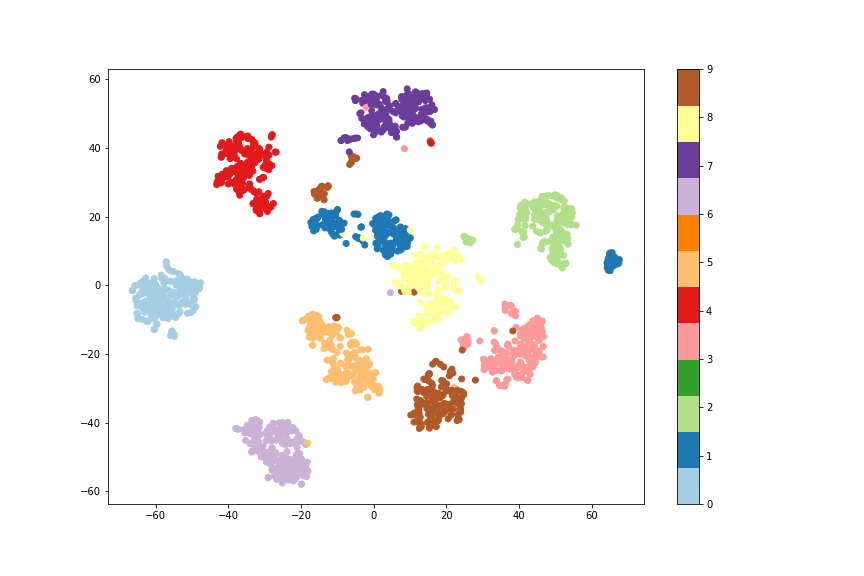

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_digits = tsne.fit_transform(digits.data)

plt.figure(figsize=(12, 8))
plt.scatter(tsne_digits[:, 0], tsne_digits[:, 1], c=digits.target, cmap='Paired')
plt.colorbar()

You can see that t-SNE does a better job of separating groups of digits into clusters, indicating there are patterns in the data that machine learning can exploit. The chief drawback is that t-SNE is compute-intensive, which means it can take a prohibitively long time to run on large datasets. One way to mitigate that is to run t-SNE on a subset of rows rather than the entire dataset. Another strategy is to use PCA to reduce the number of dimensions, and then subject the PCAed dataset to t-SNE.